In [1]:
import torch
import torch.nn as nn
from einops import rearrange, reduce, repeat
import gin
import matplotlib.pyplot as plt

## SPE

In [2]:
class SPE(torch.nn.Module):

    def __init__(self, dim=128, max_positions=10000, scale=20):
        super().__init__()
        self.embedding_size = dim
        self.max_positions = max_positions
        self.scale = scale

    def forward(self, x):
        x = x * self.scale
        freqs = torch.arange(start=0,
                             end=self.embedding_size // 2,
                             dtype=torch.float32,
                             device=x.device)
        w = (1 / self.max_positions)**(2 * freqs / self.embedding_size)
        w = w[None, :]
        x = x[:, None]
        x = torch.cat([torch.sin(w * x), torch.cos(w * x)], dim=-1)
        return x.squeeze(1)


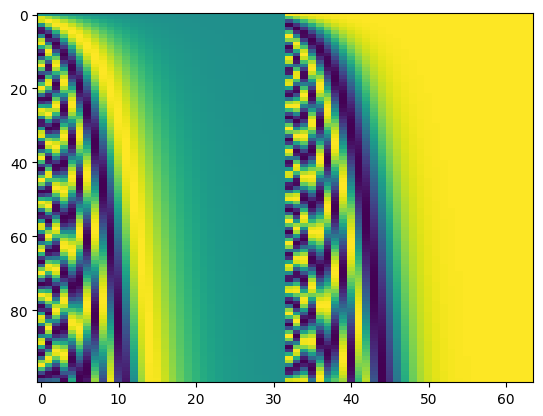

In [3]:
spe = SPE(dim = 64, max_positions=10000, scale= 100.)

t = torch.linspace(0.001, 1, 100)
out = spe(t)
plt.figure()
plt.imshow(out, aspect='auto')


### UNET

In [4]:
gin.enter_interactive_mode()

In [5]:
@gin.configurable
class ConvBlock2D(nn.Module):

    def __init__(self,
                 in_c,
                 out_c,
                 time_channels,
                 kernel_size,
                 act=nn.SiLU,
                 res=True, 
                 normalize = False):
        super().__init__()
        self.res = res

        self.conv1 = nn.Conv2d(in_c,
                               out_c,
                               kernel_size=kernel_size,
                               padding = "same")
        
        
        self.gn1 = nn.GroupNorm(min(16, in_c//4), in_c) if normalize else nn.Identity()
        
        self.conv2 = nn.Conv2d(out_c,
                               out_c,
                               kernel_size=kernel_size,
                               padding = "same")
        
        self.gn2 = nn.GroupNorm(min(16, (out_c)//4), out_c)  if normalize else nn.Identity()
        self.act = act()

        self.time_mlp = nn.Sequential(nn.Linear(time_channels, 128), act(),
                                      nn.Linear(128, 2 * out_c))
        
        if in_c != out_c:
            self.to_out = nn.Conv2d(in_c,
                                    out_c,
                                    kernel_size=1,
                                    padding="same")
        else:
            self.to_out = nn.Identity()

    def forward(self, x, time=None):
        res = x.clone()
            
        x = self.gn1(x)
        x = self.act(x) 
        x = self.conv1(x)
        time = self.time_mlp(time)
        time_mult, time_add = torch.split(time, time.shape[-1] // 2, -1)
        x = x * time_mult[:, :, None, None] + time_add[:, :, None, None]

        x = self.gn2(x)
        x = self.act(x)
        x = self.conv2(x)
    
        if self.res:
            return x + self.to_out(res)

        return x

@gin.configurable
class EncoderBlock2D(nn.Module):

    def __init__(self,
                 in_c,
                 out_c,
                 time_channels,
                 kernel_size=3,
                 ratio=2,
                 act=nn.SiLU):
        super().__init__()
        
        self.conv = ConvBlock2D(in_c=in_c,
                                out_c=out_c,
                                time_channels=time_channels,
                                kernel_size=kernel_size,
                                act=act)

        self.pool = nn.Conv2d(out_c, out_c, stride = ratio, kernel_size=3, padding=(ratio+1)//2)
        
    def forward(self, x, time):
        skip = self.conv(x, time=time)
        out = self.pool(skip)
        return out, skip

@gin.configurable
class MiddleBlock2D(nn.Module):

    def __init__(self,
                 in_c,
                 time_channels,
                 kernel_size=3,
                 act=nn.SiLU,
    ):
        super().__init__()
        
        self.conv = ConvBlock2D(in_c=in_c,
                                out_c=in_c,
                                time_channels=time_channels,
                                kernel_size=kernel_size,
                                act=act)
        
        
            
    def forward(self, x, time):
        x = self.conv(x, time=time)
        return x

@gin.configurable
class DecoderBlock2D(nn.Module):

    def __init__(self,
                 in_c,
                 out_c,
                 time_channels,
                 kernel_size,
                 res = True,
                 act=nn.SiLU,
                 ratio=2,
                 upsample_nearest = True):
        super().__init__()
        
        if ratio == 1:
            self.up = nn.Identity()
        else:        
            if upsample_nearest==True:
                conv = nn.Conv2d(in_c, in_c, kernel_size=3, stride=1,
                          padding= "same",
                          )
                self.up = nn.Sequential(
                    nn.Upsample(mode='nearest', scale_factor=ratio),
                    conv)
            else:
                 self.up = nn.ConvTranspose2d(in_channels=in_c,
                               out_channels=in_c,
                               kernel_size=3, stride=ratio, padding=ratio//2)
                        

        self.conv = ConvBlock2D(in_c=in_c + in_c,
                                out_c=out_c,
                                time_channels=time_channels,
                                kernel_size=kernel_size,
                                res = res,
                                act=act)        

    def forward(self, x, skip=None, time=None):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x, time=time)
        return x

@gin.configurable
class UNET2D(nn.Module):

    def __init__(self,
                 in_size=128,
                 out_size = None,
                 channels=[128, 128, 128, 128],
                 ratios=[1, 1, 1, 2, 1],
                 kernel_size=3,
                 time_channels=64):
        
        super().__init__()
        
        self.channels = channels
        self.in_size = in_size
    
        if out_size is None:
            out_size = in_size
        
        n = len(self.channels)

        self.time_emb = SPE(time_channels)

        self.up_layers = nn.ModuleList()
        self.down_layers = nn.ModuleList()
        
        comp_ratios = []
        cur_ratio = 1
        for r in ratios:
            cur_ratio *= r
            comp_ratios.append(cur_ratio)

        self.down_layers.append(
            EncoderBlock2D(in_c=in_size,
                           out_c=channels[0],
                           time_channels=time_channels,
                           kernel_size=kernel_size,
                           ratio=ratios[0]))
            
        

        for i in range(1, n):
            self.down_layers.append(
                EncoderBlock2D(in_c=channels[i - 1],
                               out_c=channels[i],
                               time_channels=time_channels,
                               kernel_size=kernel_size,
                               ratio=ratios[i]))
            
        
        self.middle_block = MiddleBlock2D(
            in_c=channels[-1],
            time_channels=time_channels,
            kernel_size=kernel_size)
            
            
        for i in range(1,n):
            self.up_layers.append(
                DecoderBlock2D(in_c=channels[n - i],
                               out_c=channels[n - i - 1],
                               time_channels=time_channels,
                               kernel_size=kernel_size,
                               ratio=ratios[n-i],
                               res = True))

        self.up_layers.append(
            DecoderBlock2D(in_c=channels[0],
                           out_c=out_size,
                           time_channels=time_channels,
                           kernel_size=kernel_size,
                           res = False,
                           ratio=ratios[0]))
        

    def forward(self, x, time):
        time = self.time_emb(time).to(x) if time is not None else None
        skips = []
                
        for layer in self.down_layers:
            x, skip = layer(x, time=time)
            skips.append(skip)
            
        x = self.middle_block(x, time=time)
        
        for layer in self.up_layers:
            skip = skips.pop(-1)
            x = layer(x, skip = skip, time=time)
        return x


In [6]:
unet = UNET2D(in_size=3, channels=[32, 64, 128, 128], ratios=[2, 2, 2, 1, 1], kernel_size=3, time_channels=64)

allem = 0
for p in unet.parameters():
    allem += p.numel()
print(allem/1e6)

2.408992


In [7]:
image = torch.randn(1, 3, 128, 128)
t = torch.rand(1)

import time
times = []
for i in range(20):
    st = time.time()
    out_image = unet(image,t)
    
    times.append(time.time()-st)
print(torch.mean(1/torch.tensor(times)))

tensor(16.9274)


# Trainer

In [8]:
from tqdm.notebook import tqdm
device = "mps:0"

In [9]:
gin.enter_interactive_mode()

In [10]:
unet = UNET2D(in_size=3, channels=[32, 64, 128, 128], ratios=[2, 2, 2, 1, 1], kernel_size=3, time_channels=64)

allem = 0
for p in unet.parameters():
    allem += p.numel()
print(allem/1e6)

2.408992


In [11]:
image = torch.randn(1, 3, 128, 128)
t = torch.rand(1)

import time
times = []
for i in range(20):
    st = time.time()
    out_image = unet(image,t)
    
    times.append(time.time()-st)
print(torch.mean(1/torch.tensor(times)))

tensor(20.2078)


# Trainer

In [44]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
device = "mps:0"

In [45]:
class RectifiedFlow(torch.nn.Module):

    def __init__(self, model, device: str = device):
        super().__init__()
        self.model = model
        self.device = device
        self.model.to(device)
        
        
    @gin.configurable
    def train(self, train_dl1, train_dl2, iterations, grad_norm=None, display_step=5000, save_step = 10000, logdir = None):
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.model.train()
        self.logger = SummaryWriter(logdir) if logdir is not None else None
        it = 0
        pbar = tqdm(range(iterations))
        while it < iterations:
            for x1, x2 in zip(train_dl1, train_dl2):
                print("starting epoch")
                x1, (x2,_) = x1, x2
                x1, x2 = x1.to(self.device), x2.to(self.device)
                

                loss = self.step(x1, x2)
                self.optimizer.zero_grad()
                loss.backward()

                if grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(list(
                            self.model.parameters()),max_norm=grad_norm)
                    
                self.optimizer.step()
                pbar.set_postfix({"Loss": loss.item()})
                pbar.update(1)

                if it % display_step == 0:
                    self.log_samples(x1)
                    
                if it%save_step == 0:
                    d= {}
                    d["model_state"] = self.model.state_dict()
                    d["optimizer_state"] = self.optimizer.state_dict()
                    torch.save(d, f"model_{it}.pt")
                it += 1
            print("Epoch done")
                
                
    @gin.configurable            
    def log_samples(self, x1, nb_steps, n_images):
        f, ax = plt.subplots(len(nb_steps)+1, n_images, figsize=(5, 5))
        
        x1 = x1[:n_images].to(self.device)

        for i, nb_step in enumerate(nb_steps):
            x2 = self.sample(x0=x1, nb_steps=nb_step)
            
            x2 = x2.cpu().detach()
            
            for j in range(n):
                ax[i+1, j].imshow(x2[j].squeeze(), cmap='gray')
                ax[i+1, j].axis('off')
                if i == 0:
                    ax[0, j].imshow(x1[j].cpu().detach().squeeze(), cmap='gray')
                    ax[0, j].axis('off')
    
        if self.logger is not None:
            self.logger.log_image(f"Samples", f)
            
        plt.show()
                

    def step(self, x0, x1):
        target = x1 - x0
        
        t = torch.rand(x0.size(0)).to(self.device)

        t = t[:, None,None, None]
        interpolant = (1 - t) * x0 + t * x1

        model_output = self.model(interpolant, t.view(-1))

        loss = ((model_output - target)**2).mean()
        return loss

    @torch.no_grad()
    def sample(self, x0, nb_steps, return_trajectory=False):
        dt = 1 / nb_steps
        t_values = torch.linspace(0, 1, nb_steps+1)[:-1]

        x = x0.to(device)

        x_out = []
        for t in t_values:
            t = t.reshape(1).to(device)
            x = x + self.model(x, t.repeat(x.shape[0])) * dt

            x_out.append(x.cpu())

        if return_trajectory:
            return x, torch.stack(x_out, dim=-1)
        return x

    @torch.no_grad()
    def reverse_sample(self, x0, nb_steps, return_trajectory=False):
        dt = 1 / nb_steps
        t_values = torch.linspace(1, 0, nb_steps + 1)

        x = x0.to(device)

        x_out = []
        for t in t_values[:-1]:
            t = t.reshape(1).to(device)
            x = x - self.model(x, t.repeat(x.shape[0])) * dt

            x_out.append(x.cpu())

        if return_trajectory:
            return x, torch.stack(x_out, dim=-1)
        return x

    def reflow(self, pairs0, pairs1, iterations, bsize=128):
        self.model.train()
        it = 0
        pbar = tqdm(range(iterations))

        while it < iterations:
            perm = torch.randperm(pairs0.size(0))
            pairs_train0 = pairs0.clone()[perm]
            pairs_train1 = pairs1.clone()[perm]

            for i in range(pairs_train1.shape[0] // bsize):
                x0 = pairs_train0[i * bsize:(i + 1) * bsize].to(self.device)
                x1 = pairs_train1[i * bsize:(i + 1) * bsize].to(self.device)

                target = x1 - x0
                t = torch.rand(x0.size(0)).to(self.device)

                t = t[:, None]
                interpolant = (1 - t) * x0 + t * x1

                t_emb = self.model.spe(t)
                model_output = self.model(interpolant, t_emb)

                loss = ((model_output - target)**2).mean()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                pbar.set_postfix({"Loss": loss.item()})
                pbar.update(1)
                it += 1

                if it % 2500 == 0:
                    nb_steps = [1, 2, 5, 10]
                    f, ax = plt.subplots(1, len(nb_steps), figsize=(20, 5))

                    x0 = d0.data[:1000]

                    for i, nb_step in enumerate(nb_steps):
                        x1 = self.sample(x0=x0, nb_steps=nb_step)
                        x1 = x1.cpu().detach()
                        ax[i].scatter(x1[:, 0], x1[:, 1])
                    plt.show()

In [40]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

# Download and load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example of iterating through the dataloader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break


torch.Size([32, 1, 32, 32]) torch.Size([32])


In [41]:
from torch.utils.data import Dataset, DataLoader

class GaussianNoiseDataset(Dataset):
    def __init__(self, num_samples, shape=(1, 32, 32), mean=0.0, std=1.0):
        self.num_samples = num_samples
        self.shape = shape
        self.mean = mean
        self.std = std

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        noise = torch.randn(self.shape) * self.std + self.mean
        return noise
# Create the dataset and dataloader
num_samples = 1000
noise_dataset = GaussianNoiseDataset(num_samples)
noise_loader = DataLoader(noise_dataset, batch_size=32, shuffle=True, drop_last = True)

# Example of iterating through the dataloader
for noise in noise_loader:
    print(noise.shape)
    break

torch.Size([32, 1, 32, 32])


 15%|█▍        | 148/1000 [00:27<01:14, 11.46it/s, Loss=1.41]

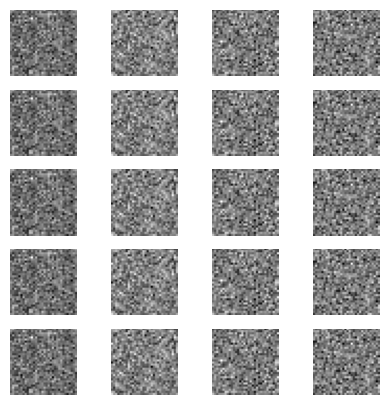

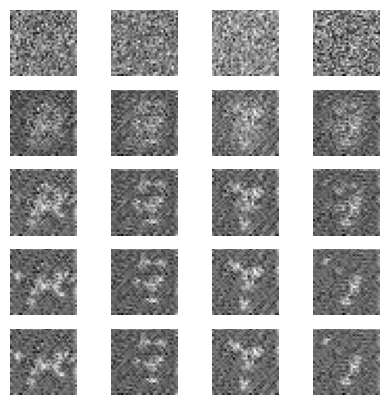

1023it [01:45,  9.73it/s, Loss=1.07]


In [42]:
unet = UNET2D(in_size=1, channels=[32, 32, 32, 32], ratios=[2, 2, 2, 1, 1], kernel_size=3, time_channels=64)

model = RectifiedFlow(model = unet, device="mps:0")

model.train(noise_loader, train_loader, 1000, display_step=1000)